# Review


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train_arr, y_train_arr), (x_test_arr, y_test_arr) = mnist.load_data()
# convert the input to tensors


2024-11-25 06:38:22.477275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732545502.489614    9986 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732545502.493403    9986 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 06:38:22.505757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


I'm getting all these errors above, but I've tested that my gpu is still working perfectly, so I was told to ignore these warnings by chatGPT.

In [2]:
x_train, x_test, y_train, y_test = tf.convert_to_tensor(x_train_arr), tf.convert_to_tensor(x_test_arr), tf.convert_to_tensor(y_train_arr), tf.convert_to_tensor(y_test_arr)


I0000 00:00:1732545506.343306    9986 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6590 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')
])

/home/jackson/code/dl/venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
scce = tf.keras.losses.SparseCategoricalCrossentropy()

pred_train = model(x_train)

loss = scce(y_train, pred_train)


In [16]:
with tf.GradientTape() as tape:
    pred_train = model(x_train)

    loss = scce(y_train, pred_train)

gradients = tape.gradient(loss, model.trainable_variables)


Reshaped gradient shape: (28, 28, 10)


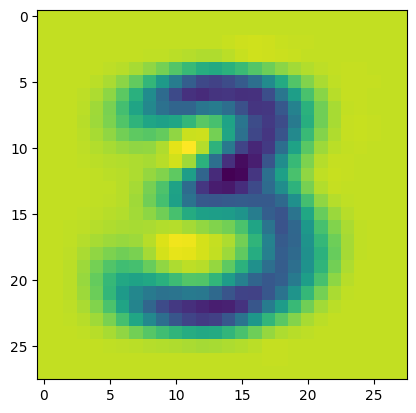

In [42]:
# let's look at gradients



from matplotlib import pyplot as plt

reshaped_gradient = tf.reshape(gradients[0], (28, 28, 10))
print("Reshaped gradient shape:", reshaped_gradient.shape)

plt.imshow(reshaped_gradient[:,:, 3])